Energy consumed in kWh: 0.6128095776866185


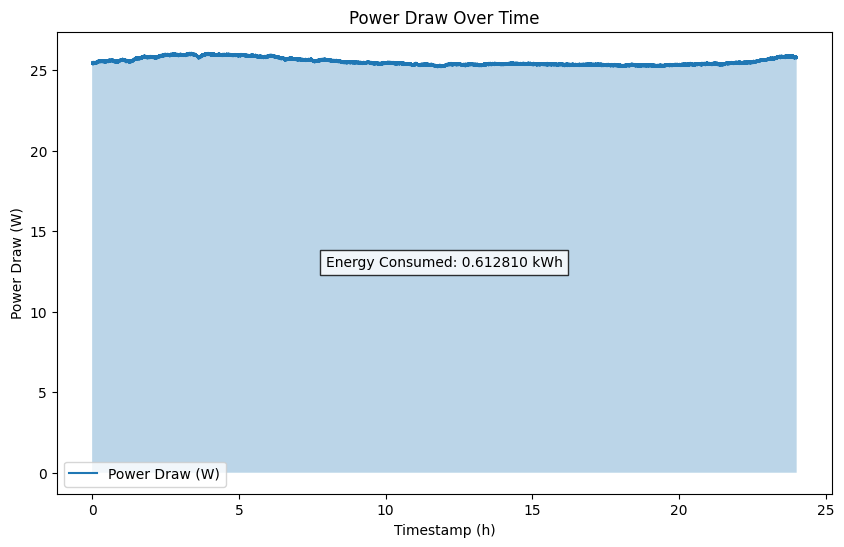

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Read the CSV file
df = pd.read_csv('/scratch/cognit/filtered_workloads/0.csv')

# Step 2: Ensure timestamp is in a numeric format and convert to hours
df['timestamp'] = pd.to_numeric(df['timestamp'])
df['timestamp_hours'] = df['timestamp'] / 3600

# Step 3: Perform the integration (numerical integration using the trapezoidal rule)
# This will give us the energy consumption in watt-seconds (Joules)
integrated_value_watt_seconds = np.trapz(df['power_draw_W'], df['timestamp'])

# Step 4: Convert watt-seconds to kilowatt-hours
# 1 watt-second = 1 joule
# 1 kWh = 3.6 million joules (3.6e6 watt-seconds)
energy_consumed_kwh = integrated_value_watt_seconds / 3.6e6

print("Energy consumed in kWh:", energy_consumed_kwh)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['timestamp_hours'], df['power_draw_W'], label='Power Draw (W)')
plt.fill_between(df['timestamp_hours'], df['power_draw_W'], alpha=0.3)
plt.xlabel('Timestamp (h)')
plt.ylabel('Power Draw (W)')
plt.title('Power Draw Over Time')
plt.legend()

# Annotating the integrated value on the plot
plt.text(0.5, 0.5, f'Energy Consumed: {energy_consumed_kwh:.6f} kWh', horizontalalignment='center',
         verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8))

plt.show()


Energy consumed in kWh: 0.6128095776866185
Total carbon emissions (g CO2e): 10.390828503927027


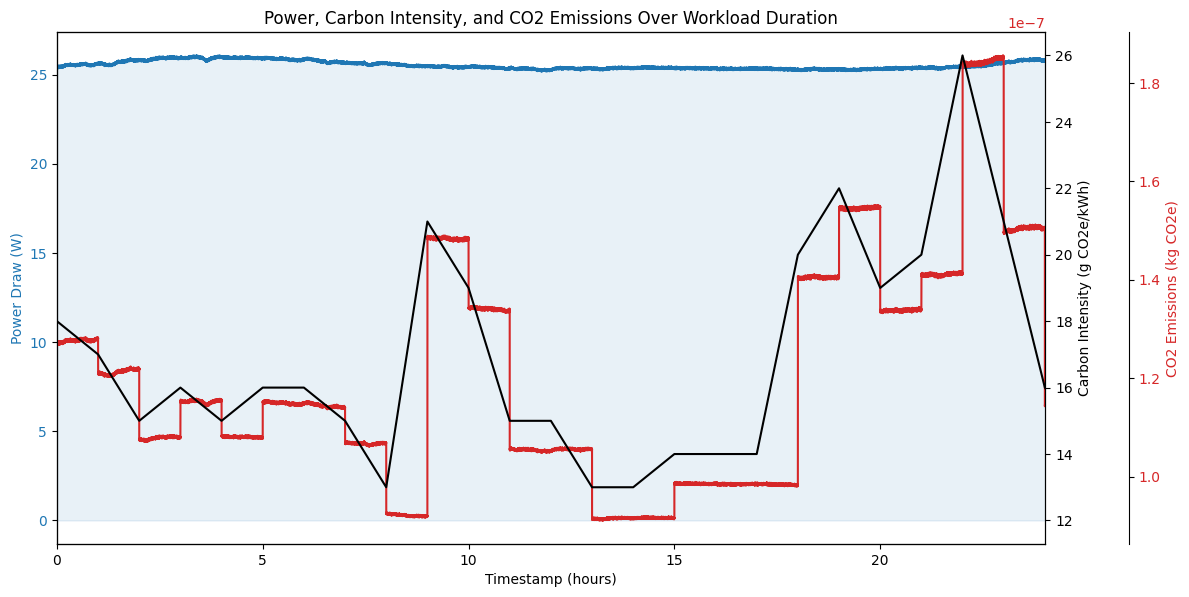

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# df_power = pd.read_csv('/scratch/cognit/filtered_workloads/20021.csv')
df_power = pd.read_csv('/scratch/cognit/filtered_workloads/0.csv')

df_power['timestamp'] = pd.to_numeric(df_power['timestamp'])

integrated_value_watt_seconds = np.trapz(df_power['power_draw_W'], df_power['timestamp'])

energy_consumed_kwh = integrated_value_watt_seconds / 3.6e6
print("Energy consumed in kWh:", energy_consumed_kwh)

#df_carbon = pd.read_csv('/scratch/cognit/carbon/PL.csv')
df_carbon = pd.read_csv('/scratch/cognit/carbon/SE-SE1.csv')
df_carbon['datetime'] = pd.to_datetime(df_carbon['datetime']).dt.tz_localize(None)
df_carbon['timestamp'] = (df_carbon['datetime'] - df_carbon['datetime'].min()) / pd.Timedelta(seconds=1)
df_merged = pd.merge_asof(df_power.sort_values('timestamp'), df_carbon[['timestamp', 'carbonIntensity']].sort_values('timestamp'), on='timestamp')

df_merged['carbonIntensity'] = df_merged['carbonIntensity'] / 1000  # Convert g CO2e/kWh to kg CO2e/kWh
df_merged['carbon_emissions'] = df_merged['power_draw_W'] * df_merged['carbonIntensity'] / 1000 / 3600

total_carbon_emissions = np.trapz(df_merged['carbon_emissions'].dropna(), df_merged['timestamp'].dropna())

print("Total carbon emissions (g CO2e):", total_carbon_emissions * 1000)

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Timestamp (hours)')
ax1.set_ylabel('Power Draw (W)', color='tab:blue')
ax1.plot(df_power['timestamp'] / 3600, df_power['power_draw_W'], label='Power Draw (W)', color='tab:blue', zorder=3)
ax1.fill_between(df_power['timestamp'] / 3600, df_power['power_draw_W'], color='tab:blue', alpha=0.1, zorder=2)
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.set_ylabel('CO2 Emissions (kg CO2e)', color='tab:red')
ax3.plot(df_merged['timestamp'] / 3600, df_merged['carbon_emissions'], label='CO2 Emissions (kg CO2e)', color='tab:red', zorder=4)
ax3.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
ax2.set_ylabel('Carbon Intensity (g CO2e/kWh)', color='black')
ax2.plot(df_carbon['timestamp'] / 3600, df_carbon['carbonIntensity'], label='Carbon Intensity (kg CO2e/kWh)', color='black', zorder=5)
ax2.tick_params(axis='y', labelcolor='black')

# Setting zorder for ax2 after ax3 ensures green line is on top
#for spine in ax3.spines.values():
#    spine.set_zorder(0)

ax1.set_xlim([0, df_power['timestamp'].max() / 3600])

fig.tight_layout()
plt.title('Power, Carbon Intensity, and CO2 Emissions Over Workload Duration')
plt.show()

Energy consumed in kWh: 0.23088191413580245


/tmp/ipykernel_13735/2053181281.py:19: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_carbon = pd.read_csv('/scratch/cognit/carbon_1s/SE-SE1.csv', dtype={'carbonIntensity': float})


Total carbon emissions (g CO2e): 4.155874454444445


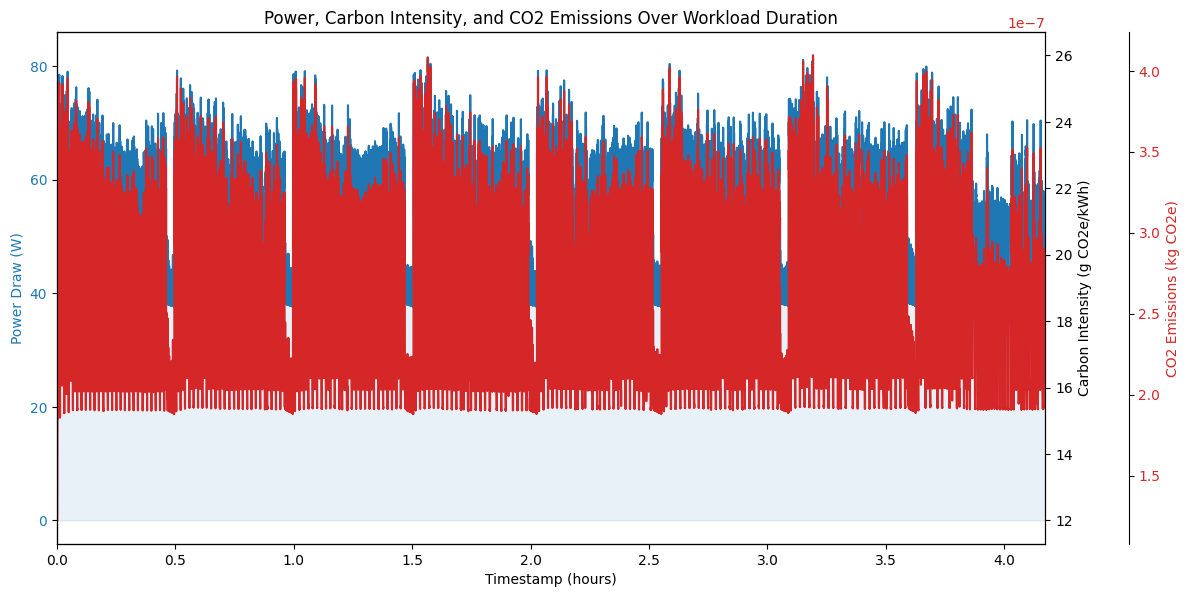

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read power draw data
df_power = pd.read_csv('/scratch/cognit/filtered_workloads/10008.csv')

# Convert timestamps to numeric
df_power['timestamp'] = pd.to_numeric(df_power['timestamp'])

# Integrate power draw to get energy consumption in watt-seconds
integrated_value_watt_seconds = np.trapz(df_power['power_draw_W'], df_power['timestamp'])

# Convert energy consumed to kWh
energy_consumed_kwh = integrated_value_watt_seconds / 3.6e6
print("Energy consumed in kWh:", energy_consumed_kwh)

# Read the new carbon intensity data with 1-second resolution
df_carbon = pd.read_csv('/scratch/cognit/carbon_1s/SE-SE1.csv', dtype={'carbonIntensity': float})

# Convert datetime to timestamp in seconds
df_carbon['datetime'] = pd.to_datetime(df_carbon['datetime']).dt.tz_localize(None)
df_carbon['timestamp'] = (df_carbon['datetime'] - df_carbon['datetime'].min()) / pd.Timedelta(seconds=1)

# Merge power and carbon data based on timestamp
df_merged = pd.merge_asof(
    df_power.sort_values('timestamp'), 
    df_carbon[['timestamp', 'carbonIntensity']].sort_values('timestamp'), 
    on='timestamp'
)

# Convert carbon intensity to kg CO2e/kWh
df_merged['carbonIntensity'] = df_merged['carbonIntensity'] / 1000

# Calculate carbon emissions (kg CO2e)
df_merged['carbon_emissions'] = df_merged['power_draw_W'] * df_merged['carbonIntensity'] / 1000 / 3600

# Integrate carbon emissions to get total emissions
total_carbon_emissions = np.trapz(df_merged['carbon_emissions'].dropna(), df_merged['timestamp'].dropna())

print("Total carbon emissions (g CO2e):", total_carbon_emissions * 1000)

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot power draw
ax1.set_xlabel('Timestamp (hours)')
ax1.set_ylabel('Power Draw (W)', color='tab:blue')
ax1.plot(df_power['timestamp'] / 3600, df_power['power_draw_W'], label='Power Draw (W)', color='tab:blue', zorder=3)
ax1.fill_between(df_power['timestamp'] / 3600, df_power['power_draw_W'], color='tab:blue', alpha=0.1, zorder=2)
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Plot CO2 emissions
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.set_ylabel('CO2 Emissions (kg CO2e)', color='tab:red')
ax3.plot(df_merged['timestamp'] / 3600, df_merged['carbon_emissions'], label='CO2 Emissions (kg CO2e)', color='tab:red', zorder=4)
ax3.tick_params(axis='y', labelcolor='tab:red')

# Plot carbon intensity
ax2 = ax1.twinx()
ax2.set_ylabel('Carbon Intensity (g CO2e/kWh)', color='black')
ax2.plot(df_carbon['timestamp'] / 3600, df_carbon['carbonIntensity'], label='Carbon Intensity (kg CO2e/kWh)', color='black', zorder=5)
ax2.tick_params(axis='y', labelcolor='black')

# Set x-axis limits
ax1.set_xlim([0, df_power['timestamp'].max() / 3600])

# Tight layout for better spacing
fig.tight_layout()

# Set plot title
plt.title('Power, Carbon Intensity, and CO2 Emissions Over Workload Duration')

# Show plot
plt.show()


In [5]:
3.6e6

3600000.0